In [ ]:
import os
import random
import tqdm
import cv2
import pandas as pd
import numpy as np

import os
from abc import ABC, abstractmethod
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from torch.optim import Adam

import matplotlib.pyplot as plt

### Split annotations in train and val

In [ ]:
anns = pd.read_csv('../input/glasses-or-no-glasses/train.csv')
anns = anns.sample(frac=1).reset_index()
train_anns, test_anns = anns.iloc[:4100], anns.iloc[4100:].reset_index()
train_anns.to_csv('./train.csv')
test_anns.to_csv('./test.csv')

In [ ]:
img_dir = '../input/glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/'
train_ann = './train.csv'
test_ann = './test.csv'

### Prepare augmentations and dataset

#### I'm gonna be training the model to classify a face crop on 128x128 images

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import torchvision.transforms as T

transform_fn = A.Compose([
    A.HorizontalFlip(),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.1, rotate_limit=30),
    A.OneOf([
        A.ChannelShuffle(p=1.),
        A.RGBShift(p=1.),
        A.RandomBrightnessContrast()
    ], p=0.3),
    A.OneOf([
        A.IAAAdditiveGaussianNoise(p=1.),
        A.GaussNoise(),
    ], p=0.3)
])

normalize_fn = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [ ]:
class GlassesDataset(Dataset):
    def __init__(self, img_dir, ann_fp, 
                 split='train', image_size=(64, 64)):
        super(GlassesDataset, self).__init__()
        self.img_dir = img_dir
        self.split = split
        self.image_size = image_size
        assert os.path.exists(ann_fp)
        self.anns = pd.read_csv(ann_fp)[['id', 'glasses']]
        self.anns_list = {0: list(anns[anns.glasses == 0].id.values), 
                          1: list(anns[anns.glasses == 1].id.values)}
        
    def __getitem__(self, idx):
        if self.split == 'train':
            clazz = random.sample(self.anns_list.keys(), 1)[0]
            id = random.sample(self.anns_list[clazz], 1)[0]
        else:
            id, clazz = self.anns.iloc[idx].values
        img_fp = os.path.join(self.img_dir, "face-{}.png".format(id))
        img = cv2.imread(img_fp)[..., ::-1]
        if self.split == 'train':
            img = transform_fn(image=img)['image']
        img = self.get_input(img)
        labels = np.array([clazz])
        labels = torch.from_numpy(labels).long()
        return img, labels
    
    def get_input(self, img):
        img = cv2.resize(img, self.image_size)
        return normalize_fn(img)

    def __len__(self):
        if self.split == 'train':
            return min(len(v) for v in self.anns_list.values())
        else:
            return len(self.anns)

### Build a model

#### To fit into 3Mb limit I decided to modify MobilenetV2 structure a bit by decreasing values of expansion in inverted blocks and number of layers

#### I also checked model's inference time on NVIDIA TESLA P100 and got the result of 3.47 ms ± 38.6 µs for a. single 128x128 image 

In [ ]:
import torch.nn as nn
from torch import Tensor
from typing import Callable, Any, Optional, List


def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNReLU(nn.Sequential):
    def __init__(
        self,
        in_planes: int,
        out_planes: int,
        kernel_size: int = 3,
        stride: int = 1,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        padding = (kernel_size - 1) // 2
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(
        self,
        inp: int,
        oup: int,
        stride: int,
        expand_ratio: int,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        # if expand_ratio != 1:
        #     # pw
        #     layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            # dw
            ConvBNReLU(inp, hidden_dim, stride=stride, groups=1, norm_layer=norm_layer),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetSmall(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(MobileNetSmall, self).__init__()

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 16
        last_channel = 320

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 8, 1, 1],
                [1, 16, 2, 2],
                [2, 32, 2, 2],
                [2, 48, 2, 2],
                [2, 64, 2, 1],
                [2, 96, 2, 2],
                [2, 128, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1 => must use reshape with x.shape[0]
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

### Training utils, nothing interesting here

In [ ]:
class CSVLogger:
    def __init__(self, log_dir, headers_list):
        self.input_file = open(os.path.join(log_dir, 'log.csv'), 'w')
        self.headers_list = headers_list
        self.log_head()

    def log_head(self):
        self.input_file.write(';'.join(self.headers_list) + '\n')
        self.input_file.flush()

    def log(self, log_dict):
        output_list = map(str, [log_dict[header] for header in self.headers_list])
        self.input_file.write(';'.join(output_list) + '\n')
        self.input_file.flush()

    def close(self):
        self.input_file.close()

        
class F1Score:
    def __init__(self):
        self._predictions = []
        self._targets = []

    def refresh(self):
        self._predictions = []
        self._targets = []

    def update(self, predictions, targets):
        self._predictions.append(np.argmax(predictions[:, :], axis=1))
        self._targets.append(targets[:, 0])

    def calculate(self):
        predictions = np.concatenate(self._predictions)
        targets = np.concatenate(self._targets)
        prs, rcls, f1s, sups = precision_recall_fscore_support(targets, predictions)
        return f1s.mean()
    
    

CHECKPOINT_DIR_NAME = 'checkpoint'
def save_checkpoint(output_dir, model, optimizer, epoch, name):
    if not os.path.exists(os.path.join(output_dir, CHECKPOINT_DIR_NAME)):
        os.makedirs(os.path.join(output_dir, CHECKPOINT_DIR_NAME), exist_ok=True)

    checkpoint_path = os.path.join(output_dir, CHECKPOINT_DIR_NAME, f'{name}.pth')

    checkpoint_dict = {
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, checkpoint_path)

In [ ]:
def train_single_epoch(model, dataloader, criterion, optimizer, epoch, postfix_dict):
    model.train()
    total_step = len(dataloader)

    total_loss = 0
    tbar = tqdm.tqdm(enumerate(dataloader), total=total_step)
    for i, (images, targets) in tbar:
        images = images.cuda()
        targets = targets.cuda()
        outputs = model(images)

        loss = criterion(outputs, targets[...,0])

        total_loss += loss.item()
        postfix_dict['train/loss'] = loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        f_epoch = epoch + i / total_step

        postfix_dict['lr'] = optimizer.param_groups[0]['lr']

        desc = '{:5s}'.format('train')
        desc += ', {:06d}/{:06d}, {:.2f} epoch'.format(i, total_step, f_epoch)
        tbar.set_description(desc)
        tbar.set_postfix(**postfix_dict)

    total_loss /= len(dataloader)
    return total_loss


def evaluate_single_epoch(model, dataloader, criterion, epoch, postfix_dict, metrics_dict):
    model.eval()

    with torch.no_grad():
        total_step = len(dataloader)

        loss_list = []
        tbar = tqdm.tqdm(enumerate(dataloader), total=total_step)
        for i, (images, targets) in tbar:
            images = images.cuda()
            targets = targets.cuda()
            outputs = model(images)

            loss = criterion(outputs, targets[..., 0])
            loss_list.append(loss.item())

            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()

            for _, metric_inst in metrics_dict.items():
                metric_inst.update(outputs, targets)

            f_epoch = epoch + i / total_step
            desc = '{:5s}'.format('val')
            desc += ', {:06d}/{:06d}, {:.2f} epoch'.format(i, total_step, f_epoch)
            tbar.set_description(desc)
            tbar.set_postfix(**postfix_dict)

        return sum(loss_list) / len(loss_list)


def train(model, criterion, optimizer, batch_size=16, num_epochs=50):
    model = model.cuda()

    experiment_dir = './'
    train_dataset = GlassesDataset(img_dir, train_ann, image_size=(128, 128))
    val_dataset = GlassesDataset(img_dir, test_ann, image_size=(128, 128), split='val')


    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                  num_workers=16, drop_last=True, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                                num_workers=16, drop_last=False, shuffle=False)

    metrics_dict = {'F1Score': F1Score()}

    postfix_dict = {'lr': 0.0,
                    'train/loss': 0.0,
                    'val/loss': 0.0, 
                    'val/F1Score': 0.0}

    start_epoch = 0
    best_metric_value = 0.0

    log_headers = ['epoch', 'train/loss', 'val/loss'] + list(metrics_dict.keys())
    logger = CSVLogger('./', log_headers)
    for epoch in range(start_epoch, num_epochs):
        # train phase
        train_loss = train_single_epoch(model, train_dataloader,
                                        criterion, optimizer, epoch, postfix_dict)
        # val phase
        val_loss = evaluate_single_epoch(model, val_dataloader, criterion, epoch, postfix_dict, metrics_dict)

        save_checkpoint(experiment_dir, model, optimizer, epoch, 'model')

        curr_metric_value = metrics_dict['F1Score'].calculate()

        if curr_metric_value > best_metric_value:
            best_metric_value = curr_metric_value
            save_checkpoint(experiment_dir, model, optimizer, epoch, 'best_model')

        postfix_dict['val/loss'] = val_loss
        postfix_dict['F1Score'] = curr_metric_value

        log_dict = {
            'epoch': epoch,
            'train/loss': train_loss,
            'val/loss': val_loss
        }
        log_dict.update({metric_name: metric.calculate() for metric_name, metric in metrics_dict.items()})
        logger.log(log_dict)

        for metric in metrics_dict.values():
            metric.refresh()
    logger.close()

In [ ]:
model = MobileNetSmall(num_classes=2).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = Adam(model.parameters(), lr=5e-5, weight_decay=1e-3)

In [ ]:
# Train the model for 50 epochs
train(model, criterion, optimizer)

In [ ]:
ckpt = torch.load("./glasses_best_model.pth")
model.load_state_dict(ckpt['state_dict'])
_ = model.eval()

### Testing the model

In [ ]:
val_dataset = GlassesDataset(img_dir, test_ann, image_size=(128, 128), split='val')

In [45]:
targets = []
preds = []
for (x, y) in tqdm.tqdm(val_dataset):
    p = model(x[None].cuda())
    preds.append(p.detach().cpu().numpy().argmax())
    
    targets.append(y[0].item())

100%|██████████| 400/400 [00:21<00:00, 18.86it/s]


In [46]:
from sklearn.metrics import classification_report
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.77      0.99      0.86       146
           1       0.99      0.83      0.90       254

    accuracy                           0.89       400
   macro avg       0.88      0.91      0.88       400
weighted avg       0.91      0.89      0.89       400



#### Model is definetely not perfect, although there seem to be some mistakes in the dataset itself.
#### Another improvement option would be pretraining the model in Imagenet, but I didn't have to do that

### Sample images from val dataset where model predicts Glasses

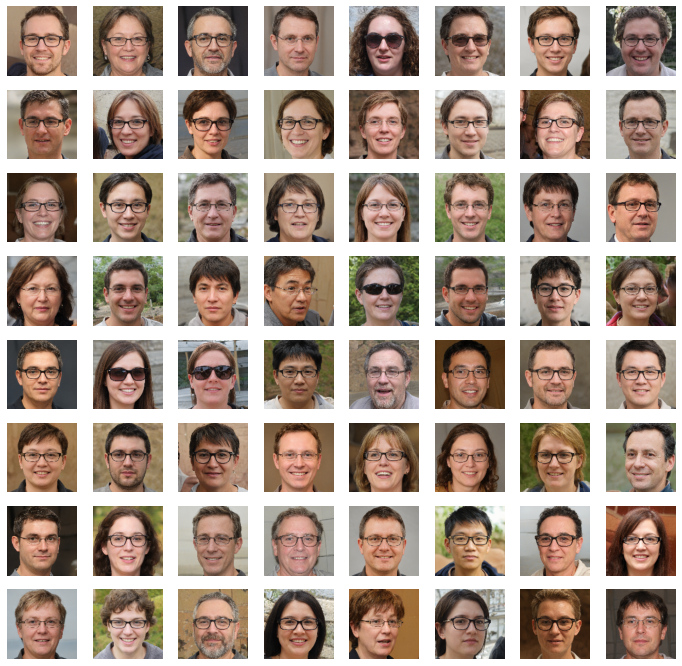

In [47]:
plt.figure(figsize=(12, 12))

# Where the model predicts Glasses
for i, idx in enumerate(random.sample(list(np.where(np.array(preds) == 1)[0]), 64)):
    x, _ = val_dataset[idx]
    plt.subplot(8, 8, i+1)
    pic = 0.5 + 0.5 * x.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(pic)
    plt.axis('off')

### Sample images from val dataset where model predicts No Glasses

In [ ]:
plt.figure(figsize=(12, 12))

# Where the model predicts Glasses
for i, idx in enumerate(random.sample(list(np.where(np.array(preds) == 0)[0]), 64)):
    x, _ = val_dataset[idx]
    plt.subplot(8, 8, i+1)
    pic = 0.5 + 0.5 * x.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(pic)
    plt.axis('off')